# METADATA
- Notebook implementing Vanilla Normalizing Flows
    - Only consider X and Y, ignore particle energy for now.
    - Scaling the X and Y predictions to [0,125].
    - Considering only the jets with 'valid' number of hits, i.e. in the range [384, 768].
- Created: 27th June, 2021
- Author: Aditya Ahuja

In [ ]:
WANDB_DESC = 'Setting up BNAF.'

# PRELIMINARY

- Need PyTorch 1.9.0+cu102 for BNAF.

In [ ]:
%%capture
! pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install wandb

In [ ]:
import torch
assert torch.__version__ == '1.9.0+cu102'
! pip list | grep torch

torch                         1.9.0+cu102        
torchsummary                  1.5.1              
torchtext                     0.10.0             
torchvision                   0.10.0+cu102       


In [ ]:
! wandb login

## Preliminary

In [ ]:
### COLAB ###

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Install missing packages
! apt-get install tree >/dev/null

# Download dataset
# ! ./get_dataset.sh

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Input format of files in $ROOT/data
INPUT_FORMAT = 'Boosted_Jets_Sample-{}.snappy.parquet'

In [ ]:
''' DOING IMPORTS '''

%matplotlib inline

import os
import cv2
import wandb
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.auto import tqdm, trange
import torch.nn.functional as F

# Set Numpy Print Options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [ ]:
''' CREATE AND SET DATA/CACHE DIRECTORIES '''

ROOT = '/content/drive/My Drive/_GSoC/Normalizing-Flows/'
DATA_ROOT = ROOT + "data/"
CACHE_ROOT = ROOT + "cache/"
LOGS_ROOT = ROOT + "logs/"

os.chdir(ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(CACHE_ROOT, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

# Initialize scratch space on /content for faster read-write
SCRATCH_ROOT = '/content/scratch/'   
os.makedirs(SCRATCH_ROOT, exist_ok=True) 

# print('Directory Structure [Excluding Log/Temp Files]:')
! tree -I 'model*|temp__*|wandb*|run_'

.
├── cache
│   └── X_dict.pkl
├── data
│   ├── Boosted_Jets_Sample-0.snappy.parquet
│   ├── Boosted_Jets_Sample-1.snappy.parquet
│   ├── Boosted_Jets_Sample-2.snappy.parquet
│   ├── Boosted_Jets_Sample-3.snappy.parquet
│   └── Boosted_Jets_Sample-4.snappy.parquet
├── get_dataset.sh
├── logs
├── nbs
│   ├── nb1.ipynb
│   ├── nb2.ipynb
│   └── Starter.ipynb
├── README.md
├── requirements.txt
└── results

5 directories, 12 files


### [ Not Needed ] Previous Data Loading functions.

In [ ]:
# ''' FUNCTIONS: DATA/INSTANCE LOADING '''

# def load_dataset(dataset_file):
#     f_path = DATA_ROOT + dataset_file
#     data = pq.read_table(f_path)
#     return data
        
# def get_instance(data, idx):
#     assert idx < 32000
#     instance = np.array(data[0][idx].as_py())
#     return instance

In [ ]:
# ''' FUNCTIONS: PARSING/VISUALIZING IMAGES '''

# def parse_img(track_img, reduce=False):
#     if reduce:
#         track_img = cv2.resize(track_img, dsize=(25,25))
#         # plt.imshow(track_img)
        
#     x_pos = []
#     y_pos = []
#     val = []
#     for x_idx in range(track_img.shape[0]):
#         for y_idx in range(track_img.shape[1]):
#             if track_img[x_idx][y_idx] != 0:
#                 val.append(track_img[x_idx][y_idx])
#                 x_pos.append(x_idx)
#                 y_pos.append(y_idx)
    
#     if reduce:
#         x_pos = [5*v for v in x_pos]
#         y_pos = [5*v for v in y_pos]
#     # print(len(x_pos), len(y_pos), len(val))
#     return x_pos, y_pos, val

# def vis(img, title=None, scale=1000, cmap='gist_heat', reduce=False):        
#     x_pos, y_pos, val = parse_img(img, reduce)
#     if scale:
#         sz = np.array(np.abs(val))*scale
#     else:
#         sz = np.ones_like(val) * 10
        
#     plt.figure(figsize=[14,6], facecolor='#f0f0f0')
#     cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
#     sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
#     plt.colorbar(sc)
#     plt.xlim(0, 125)
#     plt.ylim(0, 125)
#     plt.grid()
#     if title:
#         plt.title(title)
#     plt.show()

In [ ]:
# ''' ANALYSING PARSED IMAGES '''

# if DO_ANALYSIS:
#     dataset_file = INPUT_FORMAT.format(0)
#     data = load_dataset(dataset_file)
    
#     img = get_instance(data, 2)
#     vis(img[0], scale=500, title='Track')
#     vis(img[1], scale=200, title='ECAL')
#     vis(img[2], scale=300, title='HCAL', reduce=True)

In [ ]:
# ''' LOADING THE SINGLE PARSED DATASET '''

# def load_cached_dataset(file_name):
#     with open(CACHE_ROOT + file_name, 'rb') as f:
#         X_dict = pkl.load(f)
#     X_track = X_dict['X_track']
#     X_ECAL = X_dict['X_ECAL']
#     X_HCAL = X_dict['X_HCAL']
#     return X_track, X_ECAL, X_HCAL

# X_track, X_ECAL, X_HCAL = load_cached_dataset('X_dict.pkl')
# print(len(X_track), len(X_ECAL), len(X_HCAL))

In [ ]:
# dataset_file = INPUT_FORMAT.format(0)
# data = load_dataset(dataset_file)    

# LOAD DATA

### Dataset Class

In [ ]:
i = 10
while i<20:
    print(i)
    i += 1

10
11
12
13
14
15
16
17
18
19


In [ ]:
import torch
from torch.utils.data import *

class ParquetDataset(Dataset):
    def __init__(self, filename, channels=[1], max_instances=768, min_instances=384):
        self.parquet = pq.ParquetFile(filename)
        self.cur_idx = 0
        self.total_len = self.parquet.num_row_groups
        self.cols = None 
        self.verbose = False                # False by default
        self.max_instances = max_instances  # Number of max hits to force in each jet.
        self.min_instances = min_instances  # Number of min hits to force in each jet.
        
        
    def __getitem__(self, index):
        raise NotImplementedError('Not needed. Using `get_next_valid_instance` instead.')

    def __len__(self):
        raise NotImplementedError('Not needed. Using `get_next_valid_instance` instead.')

    def get_next_instance(self):
        '''
        Returns the next valid sample, with it's true index.
        Keeps looping until a valid sample is found.
        '''
        allowed_range = range(self.min_instances, self.max_instances+1)
        
        while True:
            for idx in range(self.cur_idx, self.total_len):
                raw_jet = self.get_raw_instance(idx)
                parsed_jet = self.parse_img(raw_jet)
                if parsed_jet.shape[0] in allowed_range:
                    padded_jet = self.pad_instance(parsed_jet)
                    self.cur_idx = idx + 1
                    return padded_jet, idx     # Exit after finding a valid instance
                else:
                    if self.verbose:
                        print('-- Skipped instance at idx={}, shape={}'.format(idx, parsed_jet.shape))

            # End of dataset, loop back.
            self.cur_idx = 0

    def get_raw_instance(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        data['X_jets'] = data['X_jets'][0:]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0.     # Zero-Suppression
        raw_jet = dict(data)['X_jets'][1]               # Temporary Hack for Ecal
        return raw_jet

    def parse_img(self, track_img, reduce=False):
        '''
        Returns non-zero hits from the single-channel input jet image - `track_img`. 
        '''
        track_img = torch.Tensor(track_img)        
        x_pos, y_pos = torch.nonzero(track_img, as_tuple=True)
        val = track_img[x_pos, y_pos]
        out = torch.stack((x_pos,y_pos),dim=1)        
        if self.verbose:
            print('-- Output Shape:', out.shape)
        return out

    def pad_instance(self, instance):
        assert instance.shape[0] <= self.max_instances
        assert instance.shape[0] >= self.min_instances
        pad_len = self.max_instances - instance.shape[0]
        instance = F.pad(instance, pad=(0, 0, 0, pad_len), mode='constant', value=0)
        return instance

In [ ]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    '''
    Visualise a jet instance.
    '''

    if not is_parsed:   
        arr = parse_img(arr, reduce)

    if arr.shape[1] == 3:
        x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]
    elif arr.shape[1] == 2:
        x_pos, y_pos = arr[:,0], arr[:,1]
        val = torch.ones_like(x_pos)
        scale = None

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [ ]:
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file)
dataset.verbose = True
print('Max Length of Dataset: ', dataset.total_len)

Max Length of Dataset:  32000


In [ ]:
for i in range(10):
    print('[{}]'.format(i))
    data_sample, true_idx = dataset.get_next_instance()
    print(data_sample.shape, true_idx)
    print(dataset.cur_idx)
    print('\n')

[0]
-- Output Shape: torch.Size([320, 2])
-- Skipped instance at idx=0, shape=torch.Size([320, 2])
-- Output Shape: torch.Size([346, 2])
-- Skipped instance at idx=1, shape=torch.Size([346, 2])
-- Output Shape: torch.Size([538, 2])
torch.Size([768, 2]) 2
3


[1]
-- Output Shape: torch.Size([1807, 2])
-- Skipped instance at idx=3, shape=torch.Size([1807, 2])
-- Output Shape: torch.Size([669, 2])
torch.Size([768, 2]) 4
5


[2]
-- Output Shape: torch.Size([656, 2])
torch.Size([768, 2]) 5
6


[3]
-- Output Shape: torch.Size([270, 2])
-- Skipped instance at idx=6, shape=torch.Size([270, 2])
-- Output Shape: torch.Size([522, 2])
torch.Size([768, 2]) 7
8


[4]
-- Output Shape: torch.Size([702, 2])
torch.Size([768, 2]) 8
9


[5]
-- Output Shape: torch.Size([655, 2])
torch.Size([768, 2]) 9
10


[6]
-- Output Shape: torch.Size([365, 2])
-- Skipped instance at idx=10, shape=torch.Size([365, 2])
-- Output Shape: torch.Size([640, 2])
torch.Size([768, 2]) 11
12


[7]
-- Output Shape: torch.Size([99,

### Check hits per jet + Outlier Analysis

In [ ]:
dataset.verbose = False
samples = []
lim = 500       # Set to 5000 for actual analysis

for i in trange(lim):
    data = dataset.__getitem__(i)
    samples.append(data.shape[0])

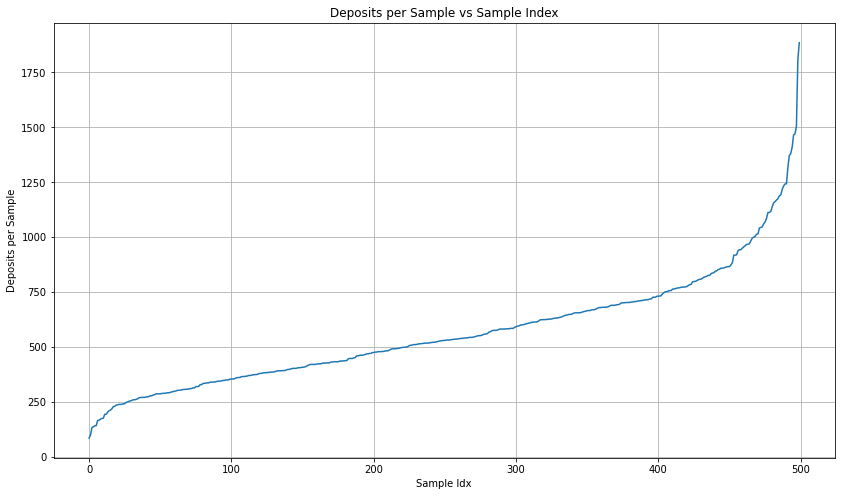

In [ ]:
plt.figure(figsize=[14,8])
plt.title('Deposits per Sample vs Sample Index')
plt.plot(sorted(samples))
plt.xlabel('Sample Idx')
plt.ylabel('Deposits per Sample')
plt.grid()
plt.show()

In [ ]:
print('90th Percentile: ', sorted(samples)[int(len(samples)*0.90)])
print('95th Percentile: ', sorted(samples)[int(len(samples)*0.95)])
print('99th Percentile: ', sorted(samples)[int(len(samples)*0.99)])

90th Percentile:  866
95th Percentile:  1069
99th Percentile:  1465


In [ ]:
idx_order = np.array(samples).argsort()[::-10]
print('Max number of samples: ', samples[idx_order[0]])

Idx: 154


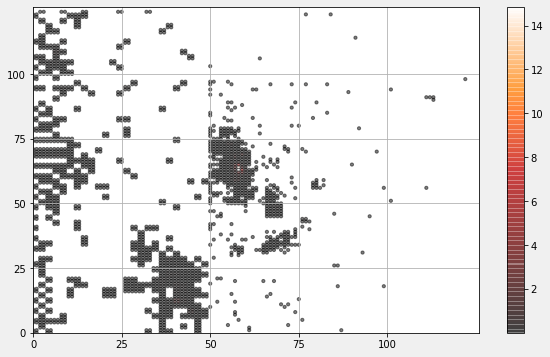




Idx: 215


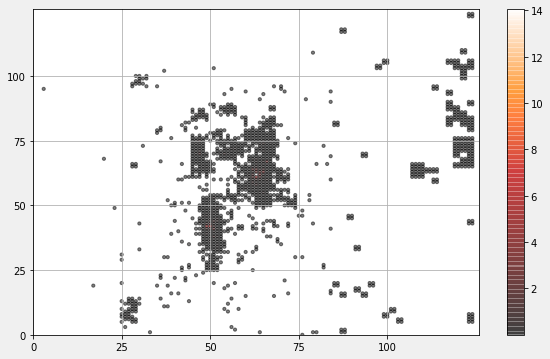




Idx: 308


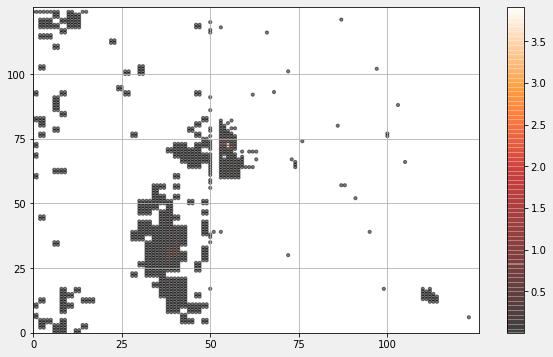




Idx: 376


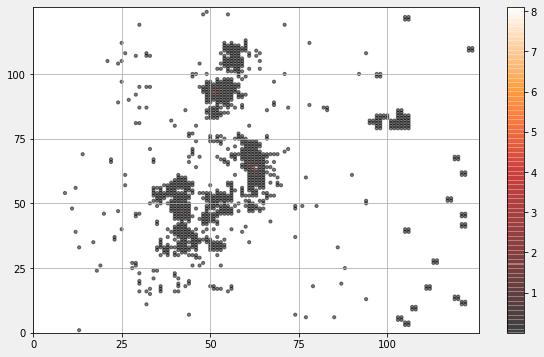




Idx: 167


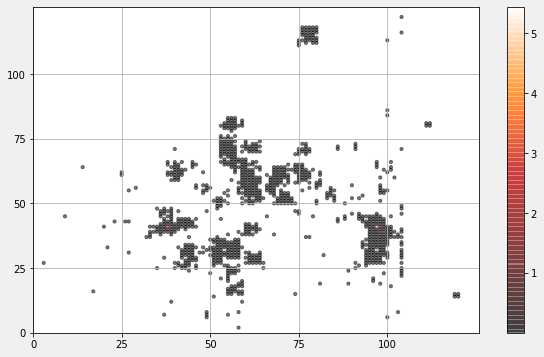




Idx: 480


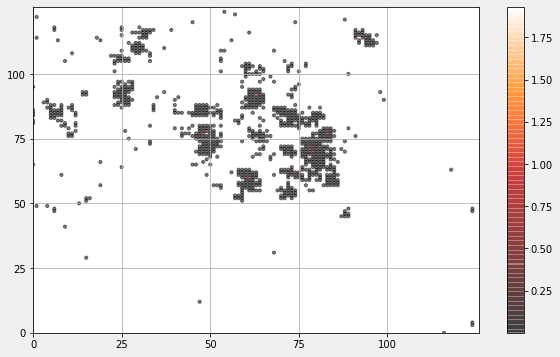




Idx: 155


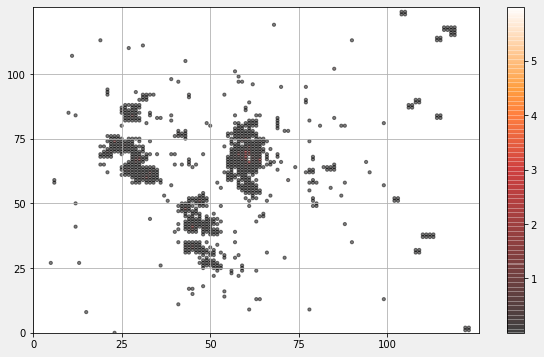




Idx: 111


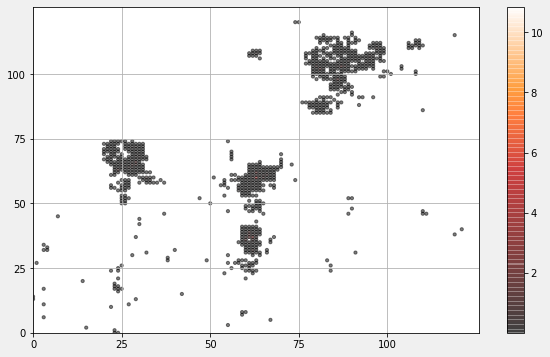




Idx: 195


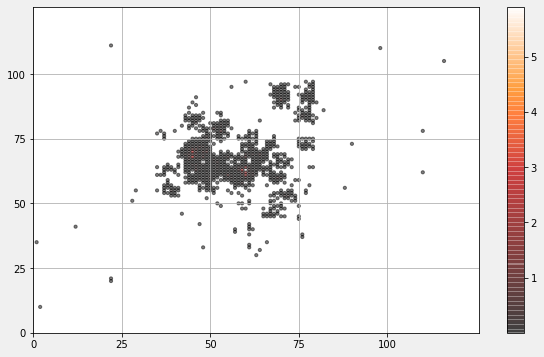




Idx: 234


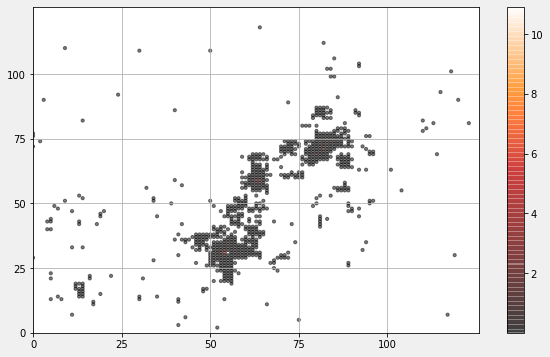

In [ ]:
# Analyse jets with a lot of hits

for i in idx_order[:10]:
    data_sample = dataset.__getitem__(i)
    print('Idx: {}'.format(i))
    vis(data_sample, scale=None)
    print('\n\n')

In [ ]:
k = dataset.__getitem__(i)
k.shape

torch.Size([320, 3])

### Checking the average jet. 

In [ ]:
xs = []
ys = []

lim = 500

for i in trange(lim):
    data = dataset.__getitem__(i)
    xs += data[:,0]
    ys += data[:,1]

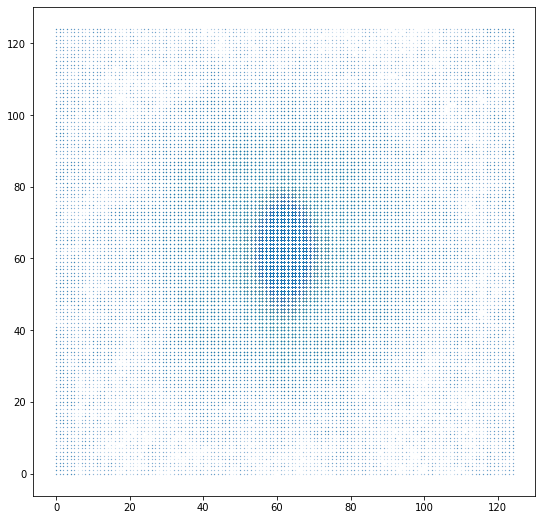

In [ ]:
# Plotting the average jet.

l = len(xs)
plt.figure(figsize=[9,9])
plt.plot(xs[:l], ys[:l], '.', markersize=0.1)
plt.show()

In [ ]:
xs = []
ys = []
vs = []

lim = 500

for idx in range(lim):
    data = dataset.__getitem__(idx)
    xs.append(data[:,0])
    ys.append(data[:,1])
    vs.append(data[:,2])

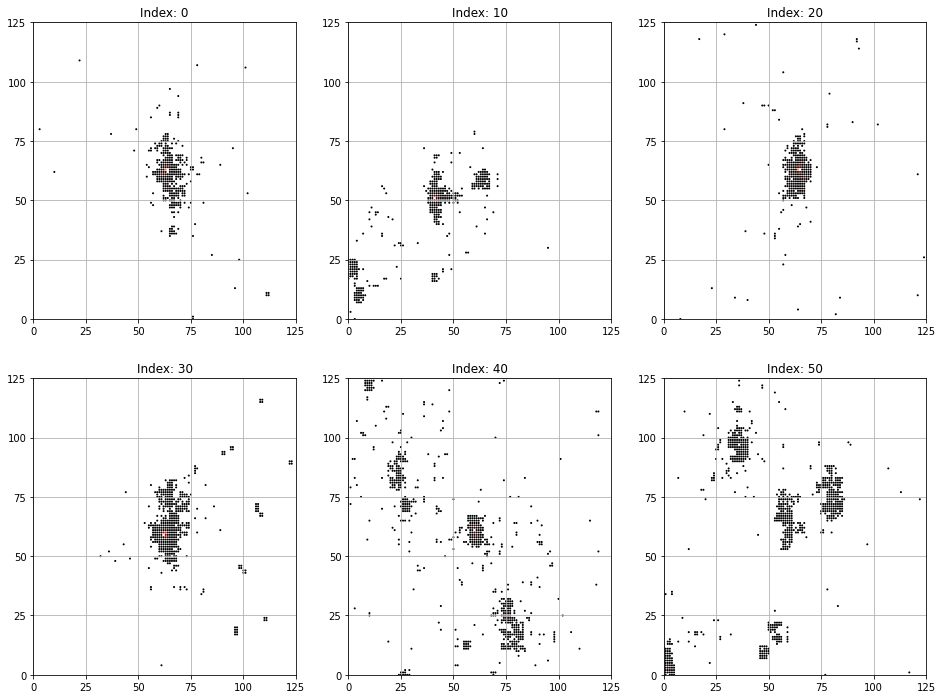

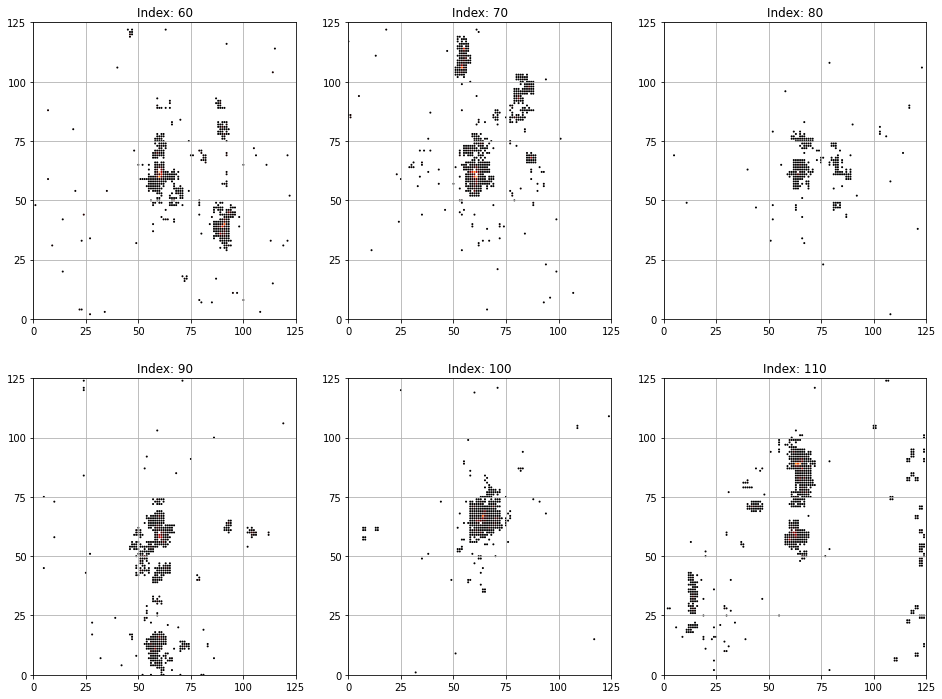

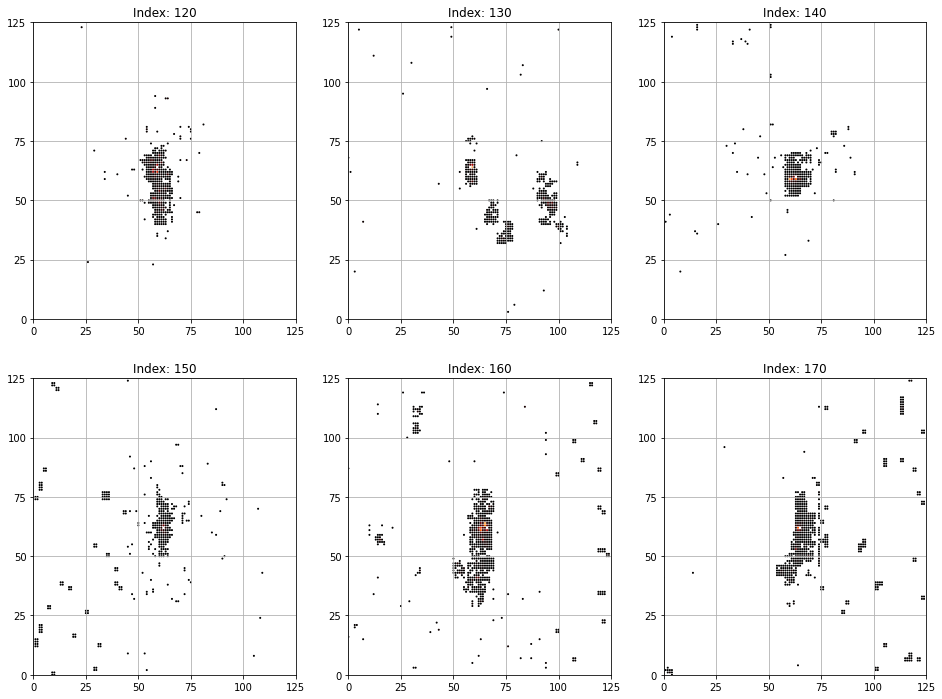

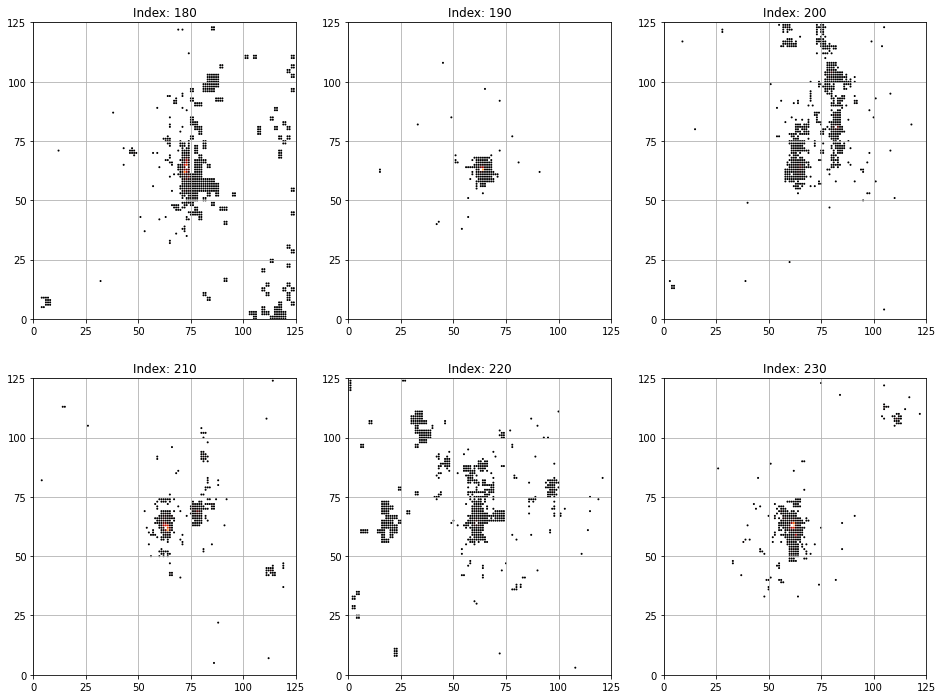

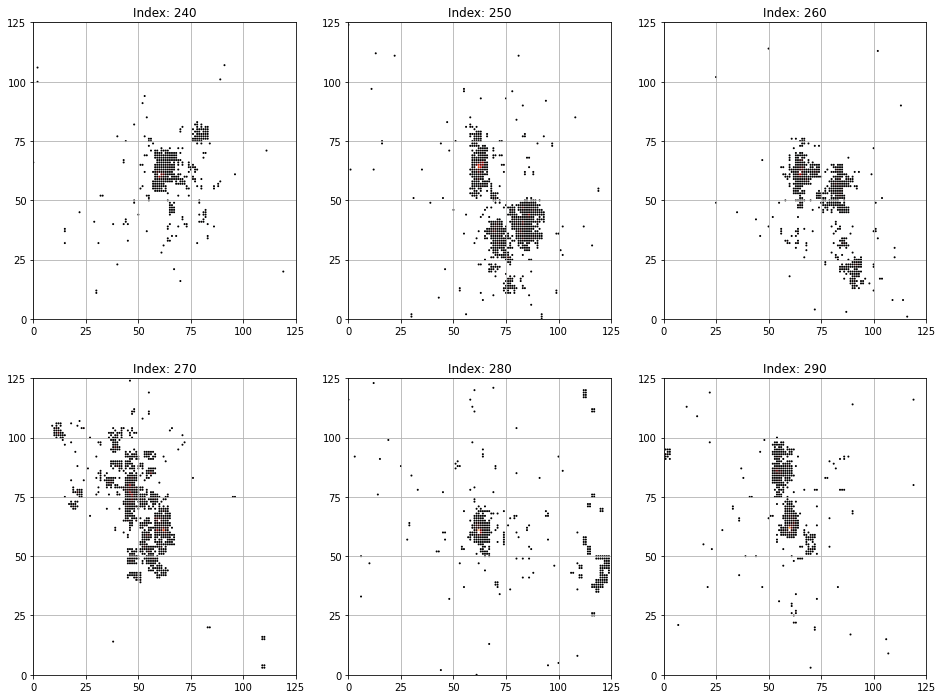

In [ ]:
# Plotting different jets.

multiplier = 10
num_rows = 2
num_cols = 3

for i in range(0, 30, num_rows*num_cols):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=[16,12])

    for ri, row in enumerate(ax):
        for ci, col in enumerate(row):
            index = multiplier * (i + ri*num_cols + ci)
            # col.plot(xs[index], ys[index], '.', markersize=3)
            col.scatter(xs[index], ys[index], c=vs[index], s=1, cmap='gist_heat', alpha=1)
            col.set_title('Index: {}'.format(index))
            col.grid()
            col.set_xlim(0,125)
            col.set_xticks(range(0,126,25))
            col.set_ylim(0,125)
            col.set_yticks(range(0,126,25))
    plt.show()

# Block Neural Autoregressive Flow

Adapted from - https://github.com/kamenbliznashki/normalizing_flows

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import math
import os
import time
import argparse
import pprint
from functools import partial

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help='Train a flow.')
    parser.add_argument('--plot', action='store_false', help='Plot a flow and target density.')
    parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
    parser.add_argument('--output_dir', default='./results/run_')
    parser.add_argument('--cuda', type=int, help='Which GPU to run on.')
    parser.add_argument('--seed', type=int, default=0, help='Random seed.')
    # model parameters
    parser.add_argument('--data_dim', type=int, default=2, help='Dimension of the data.')
    parser.add_argument('--hidden_dim', type=int, default=100, help='Dimensions of hidden layers.')
    parser.add_argument('--n_hidden', type=int, default=3, help='Number of hidden layers.')
    # training parameters
    parser.add_argument('--step', type=int, default=0, help='Current step of training (number of minibatches processed).')
    parser.add_argument('--n_steps', type=int, default=1, help='Number of steps to train.')
    parser.add_argument('--batch_size', type=int, default=200, help='Training batch size.')
    parser.add_argument('--lr', type=float, default=1e-1, help='Initial learning rate.')
    parser.add_argument('--lr_decay', type=float, default=0.5, help='Learning rate decay.')
    parser.add_argument('--lr_patience', type=float, default=2000, help='Number of steps before decaying learning rate.')
    parser.add_argument('--log_interval', type=int, default=50, help='How often to save model and samples.')

    args = parser.parse_args([])
    args.output_dir = os.path.join('./results/run_', time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime()))
    if not os.path.isdir(args.output_dir): 
        os.makedirs(args.output_dir)
    args.device = torch.device('cuda:{}'.format(args.cuda) if args.cuda is not None and torch.cuda.is_available() else 'cpu')

    return args

In [ ]:
''' Model components ''' 

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim
        # print(self.in_features, self.out_features, self.data_dim)

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        # print(x.dtype)
        # print(w.dtype)
        # print(x)
        # print(w)
        x = x.type(torch.float32)
        # print(x.dtype)
        out = F.linear(x, w, self.bias)
        # print('Out:', out.shape)


        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()


In [ ]:
''' Model '''

class BNAF(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

def compute_kl_pq_loss(model, input_data):
    input_data = input_data.to(model.base_dist.loc.device)
    z, logdet = model(input_data)
    # print(z)
    # print(logdet)
    return - torch.sum(model.base_dist.log_prob(z) + logdet, dim=1)


In [ ]:
''' Training ''' 

def train_flow(model, dataset, loss_fn, optimizer, scheduler, args):
    model.train()

    init_steps = args.step
    for _ in range(args.n_steps):
        args.step += 1

        input_data, true_index = dataset.get_next_instance()
        input_data = input_data.reshape(1,-1)
        loss = loss_fn(model, input_data).mean(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        print("Step: {:03d}/{:03d} | Loss: {:14.2f}".format(args.step, init_steps+args.n_steps, loss.item()))
        wandb.log({'Step': args.step, 
                   'Loss': loss.item(), 
                   'Learning_Rate': args.lr,
                   'True_Index': true_index})

        if args.step % args.log_interval == 0:
            # save model
            torch.save({'step': args.step,
                        'state_dict': model.state_dict()},
                        os.path.join(args.output_dir, 'checkpoint.pt'))
            torch.save({'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        os.path.join(args.output_dir, 'optim_checkpoint.pt'))


In [ ]:
# Config to initialize wandb.
DEFAULT_CFG = {
    'model': 'BNAF_Valid-Samples',
    'root_dir': ROOT,
}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Get Args
args = get_args()

# Set custom args
args.data_dim = dataset.max_instances * 2     # 768 * 2
args.hidden_dim = dataset.max_instances * 4   # 768 * 4
args.n_steps = 1000
args.log_interval = 200
args.cuda = 0
args.lr = 0.1
args.step = 0

# Set Seeds
torch.manual_seed(args.seed)
if args.device.type == 'cuda': 
    torch.cuda.manual_seed(args.seed)

# Get Model
model = BNAF(args.data_dim, args.n_hidden, args.hidden_dim).to(args.device)
if args.restore_file:
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    args.step = model_checkpoint['step']

# Save Config
config = 'Parsed args:\n{}\n\n'.format(pprint.pformat(args.__dict__)) + \
            'Num trainable params: {:,.0f}\n\n'.format(sum(p.numel() for p in model.parameters())) + \
            'Model:\n{}'.format(model)

config_path = os.path.join(args.output_dir, 'config.txt')
if not os.path.exists(config_path):
    with open(config_path, 'a') as f:
        print(config, file=f)

# Get Optimizer + Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.lr_decay, patience=args.lr_patience, verbose=True)
if args.restore_file:
    optim_checkpoint = torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device)
    optimizer.load_state_dict(optim_checkpoint['optimizer'])
    scheduler.load_state_dict(optim_checkpoint['scheduler'])

# Initialize Dataset 
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file)

# Define Loss
loss_fn = compute_kl_pq_loss

In [ ]:
# Init Wandb
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_NOTES"] = WANDB_DESC
run = wandb.init(project='gnf', config=DEFAULT_CFG, dir=LOGS_ROOT)
wandb.config.update(args)

# Save files for later
! pip freeze > requirements.txt
wandb.save(ROOT + 'requirements.txt')
# wandb.save(config_path)       # TODO: Fix permission issue on Colab.

['/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210702_125905-e1dy9bcx/files/requirements.txt',
 '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210702_125905-e1dy9bcx/files/requirements.txt']

In [ ]:
# Train The Model
train_flow(model, dataset, loss_fn, optimizer, scheduler, args)

Step: 1001/2000 | Loss:        6350.26
Step: 1002/2000 | Loss:        6239.97
Step: 1003/2000 | Loss:        6357.96
Step: 1004/2000 | Loss:        6235.07
Step: 1005/2000 | Loss:        6891.25
Step: 1006/2000 | Loss:        6571.29
Step: 1007/2000 | Loss:        7696.78
Step: 1008/2000 | Loss:        6590.26
Step: 1009/2000 | Loss:        6979.65
Step: 1010/2000 | Loss:        6592.71
Step: 1011/2000 | Loss:        6179.45
Step: 1012/2000 | Loss:        6158.07
Step: 1013/2000 | Loss:        8664.13
Step: 1014/2000 | Loss:        5980.66
Step: 1015/2000 | Loss:        6093.95
Step: 1016/2000 | Loss:        6128.44
Step: 1017/2000 | Loss:        5789.76
Step: 1018/2000 | Loss:        5916.96
Step: 1019/2000 | Loss:        5634.73
Step: 1020/2000 | Loss:        6391.32
Step: 1021/2000 | Loss:        6078.94
Step: 1022/2000 | Loss:        6033.27
Step: 1023/2000 | Loss:        6322.62
Step: 1024/2000 | Loss:        6464.36
Step: 1025/2000 | Loss:        6021.21
Step: 1026/2000 | Loss:  

In [ ]:
args.step, args.n_steps, args.lr

(1000, 1000, 0.1)

In [ ]:
# args.lr = 0.01
# args.n_steps = 1000

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def eval_bnaf(model, input_data, scale=True, verbose=False):
    zzk, logdets = model(input_data.reshape(1,-1))
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    pred = log_prob.reshape(log_prob.shape[1]//2,2).cpu().detach()

    if verbose:
        print('zzk:{}, logdets:{}'.format(zzk.shape, logdets.shape))
        print('zzk:{}, logdets:{}'.format(prob.shape, log_prob.shape))
        print('pred:{}'.format(pred.shape))

    if scale:
        scaler = MinMaxScaler()
        pred = scaler.fit_transform(pred) * 125
        pred = torch.Tensor(pred)

    return pred

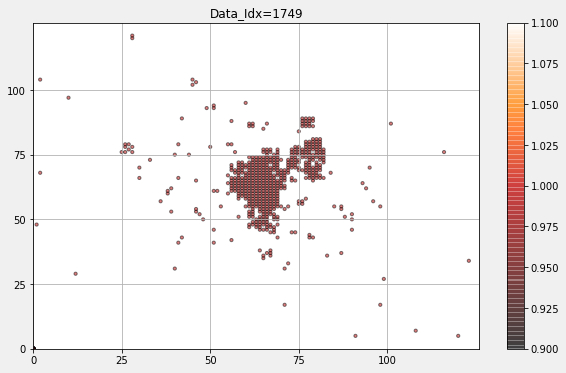

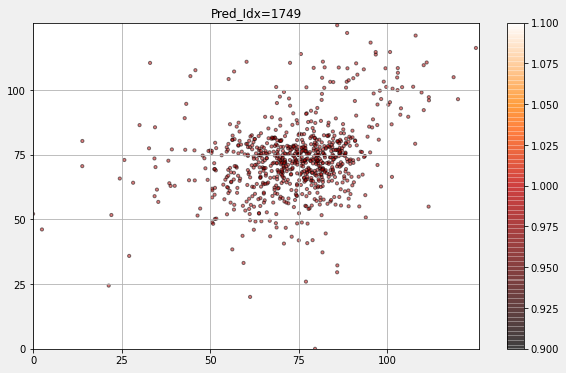

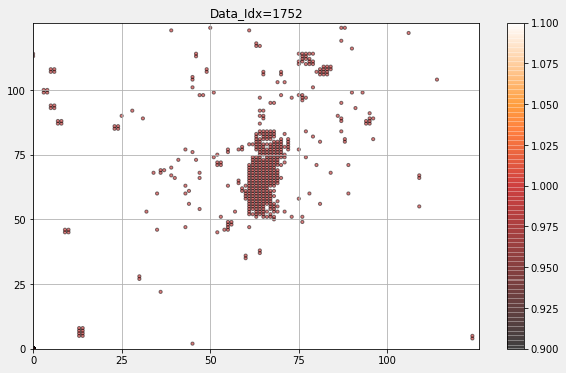

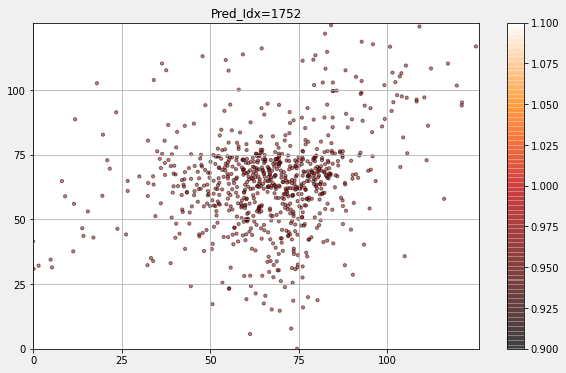

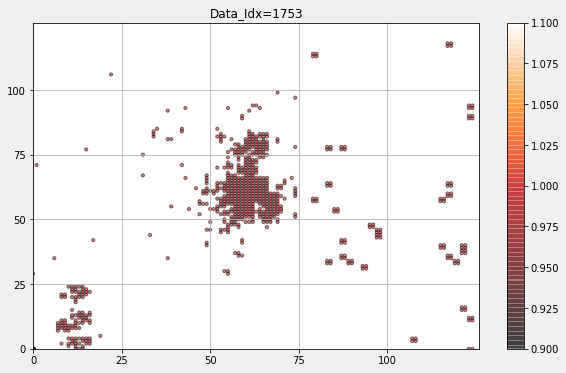

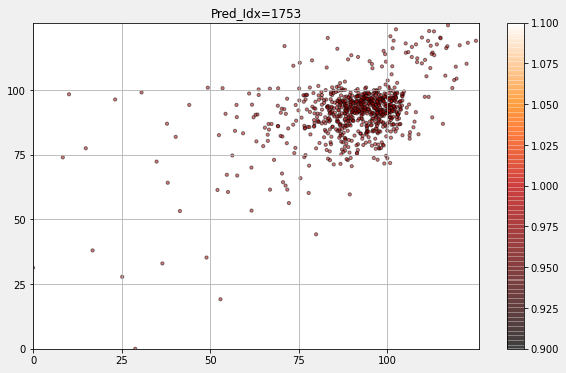

In [ ]:
for _ in range(3):
    data, true_idx = dataset.get_next_instance()
    pred = eval_bnaf(model, data, scale=True)
    vis(data, title='Data_Idx={:03d}'.format(true_idx))
    vis(pred, title='Pred_Idx={:03d}'.format(true_idx))

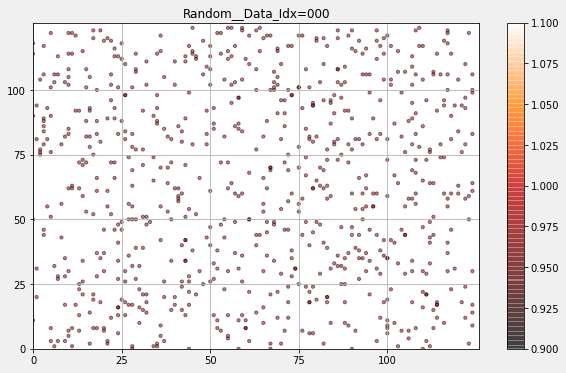

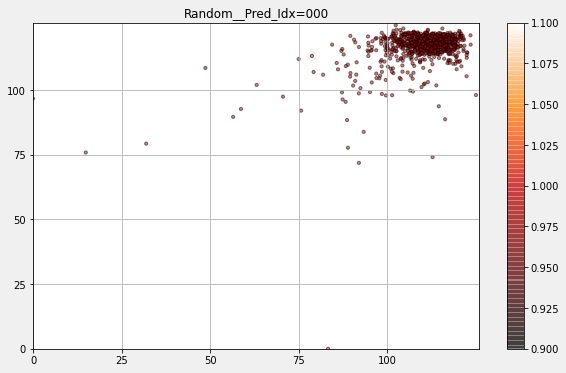

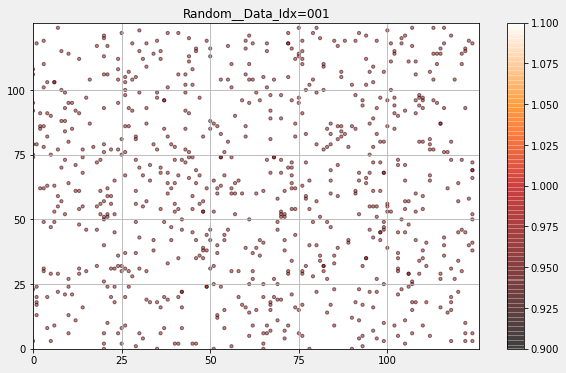

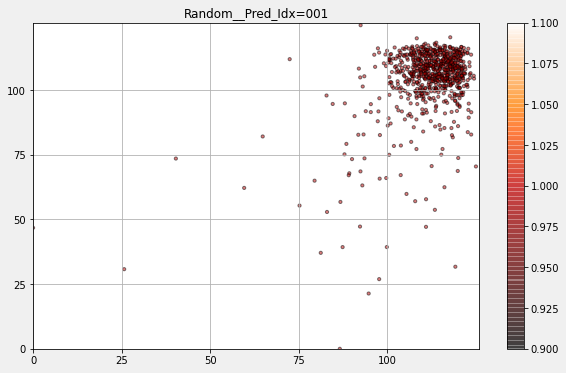

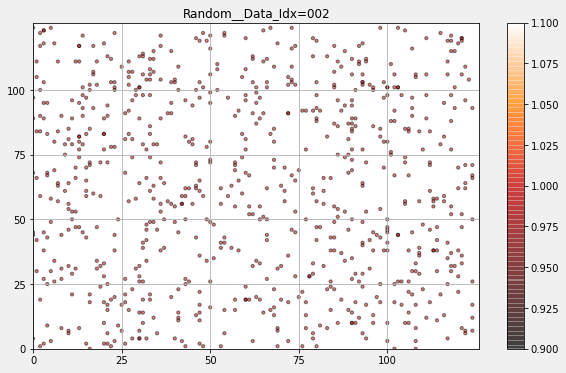

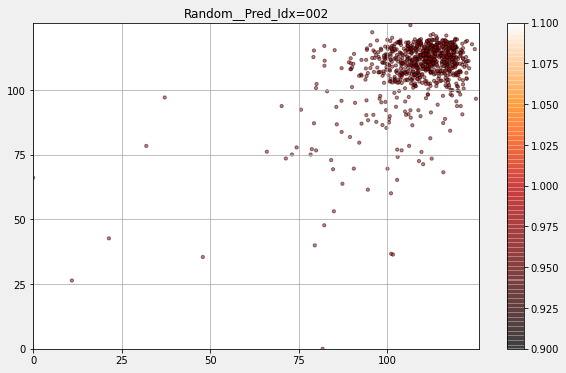

In [ ]:
def gen_random_data(dim):
    data = torch.Tensor(np.random.random(dim*2).reshape(dim,2) * 125)
    data = data.type(torch.int32)
    return data

for i in range(3):
    dim = dataset.max_instances
    random_data = gen_random_data(dim)
    random_pred = eval_bnaf(model, random_data, scale=True)
    vis(random_data, title='Random__Data_Idx={:03d}'.format(i))
    vis(random_pred, title='Random__Pred_Idx={:03d}'.format(i))

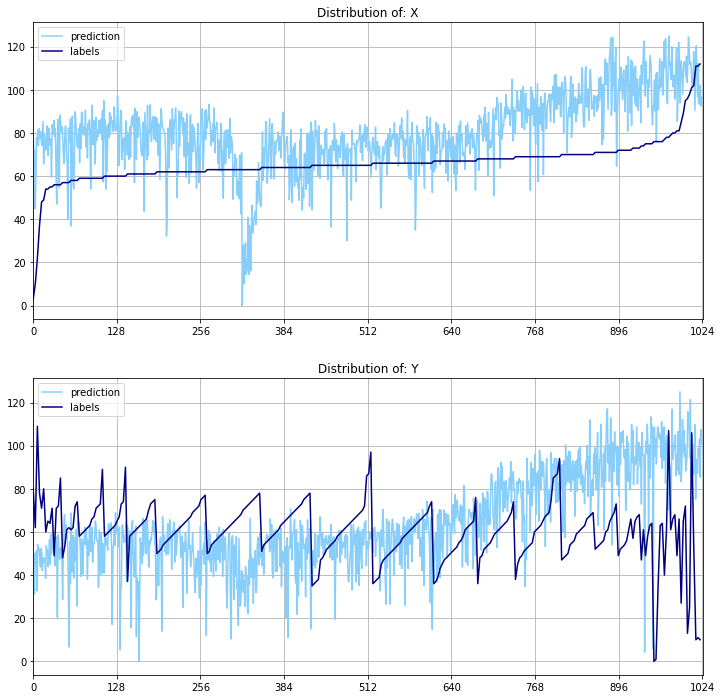

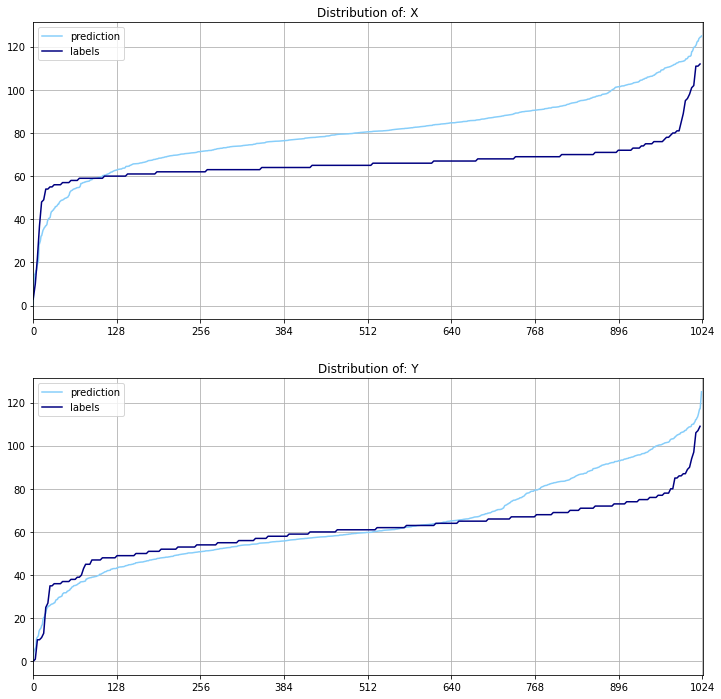

In [ ]:
def analyse_prediction(data, pred, to_sort=False):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[12,12])
    labels = ['X', 'Y']
    n_hits = len(data.nonzero()) // 2
    data = data[:n_hits]

    for i,ax in enumerate(axes):
        pred_idx = np.array(range(0,1024))
        data_idx = (1024 / n_hits) * np.array(range(0,n_hits))

        if to_sort:
            ax.plot(pred_idx, sorted(pred[:,i]), label='prediction', c='lightskyblue')
            ax.plot(data_idx, sorted(data[:,i]), label='labels', c='navy')
        else:
            ax.plot(pred_idx, pred[:,i], label='prediction', c='lightskyblue')
            ax.plot(data_idx, data[:,i], label='labels', c='navy')
        
        ax.set_title('Distribution of: {}'.format(labels[i]))
        ax.grid()
        ax.set_xlim(0,1025)
        ax.set_xticks(range(0,1025,128))
        ax.legend()
    plt.show()

analyse_prediction(input_data, pred)
analyse_prediction(input_data, pred, to_sort=True)

### Debugging Cells

In [ ]:
def plot_fwd_flow_density(model, ax, test_grid, n_pts, batch_size):
    """ plots square grid and flow density; where density under the flow is exp(log_flow_base_dist + logdet) """
    xx, yy, zz = test_grid
    # compute posterior approx density
    zzk, logdets = [], []
    for zz_i in zz.split(batch_size, dim=0):
        zzk_i, logdets_i = model(zz_i)
        zzk += [zzk_i]
        logdets += [logdets_i]
    zzk, logdets = torch.cat(zzk, 0), torch.cat(logdets, 0)
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    # plot
    ax.pcolormesh(xx, yy, prob.view(n_pts,n_pts), cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    ax.set_title('Flow density')

def setup_grid(range_lim, n_pts, args):
    x = torch.linspace(-range_lim, range_lim, n_pts)
    xx, yy = torch.meshgrid((x, x))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    return xx, yy, zz.to(args.device)

# def plot_samples(samples, ax, range_lim, n_pts):
#     samples = samples.numpy()
#     print(samples[:,0][:10])
#     exit(0)
#     ax.hist2d(samples[:,0], samples[:,1], range=[[-range_lim, range_lim], [-range_lim, range_lim]], bins=n_pts, cmap=plt.cm.jet)
#     ax.set_title('Target samples')

def plot(model, samples, args):
    n_pts = 1000
    range_lim = 4

    # construct test points
    test_grid = setup_grid(range_lim, n_pts, args)

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'aspect': 'equal'})
    # plot_samples(samples, axs[0], range_lim, n_pts)
    plot_fwd_flow_density(model, axs[1], test_grid, n_pts, args.batch_size)

    # format
    for ax in plt.gcf().axes: format_ax(ax, range_lim)
    plt.tight_layout()

plot(model, -1, args)